# Business Understanding

With changing market conditions and new pricing schemes, SyriaTel lost subscribers to competition. SyriaTel wants to know why subcribers churn. 

In [1]:
# Import libraries used in the notebook
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model

# Data Understanding
Dataset selected comes from Kaggle at https://www.kaggle.com/becksddf/churn-in-telecoms-dataset. I will explore the data, understand, before creating the dataset to use when building Machine Learning models.

In [2]:
# Read dataset into a dataframe
df = pd.read_csv('../data/churn_data.csv')
print("Data contains {} observations and {} features".format(df.shape[0], df.shape[1]))
print("Features: ", df.columns)

Data contains 3333 observations and 21 features
Features:  Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')


In [3]:
'''
    Column 'Churn' is the label field, predicted feature, dependent feature
'''

"\n    Column 'Churn' is the label field, predicted feature, dependent feature\n"

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [5]:
df.isnull().sum().any()

False

In [6]:
'''
    No null or missing data. Feature variables -Phone Number- can be dropped off later.

'''

'\n    No null or missing data. Feature variables -Phone Number- can be dropped off later.\n\n'

Target filed or the dependent vriable is 'churn'. Let us take a visualization of the target.

<AxesSubplot:>

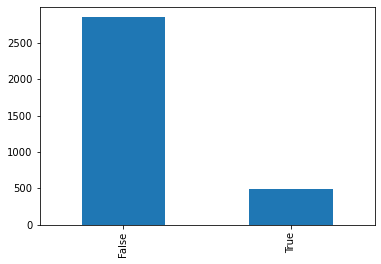

In [7]:
df['churn'].value_counts().plot(kind='bar')

Let us take a heatmap of correlation matrix

<ipython-input-9-5a9c48f20f59>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


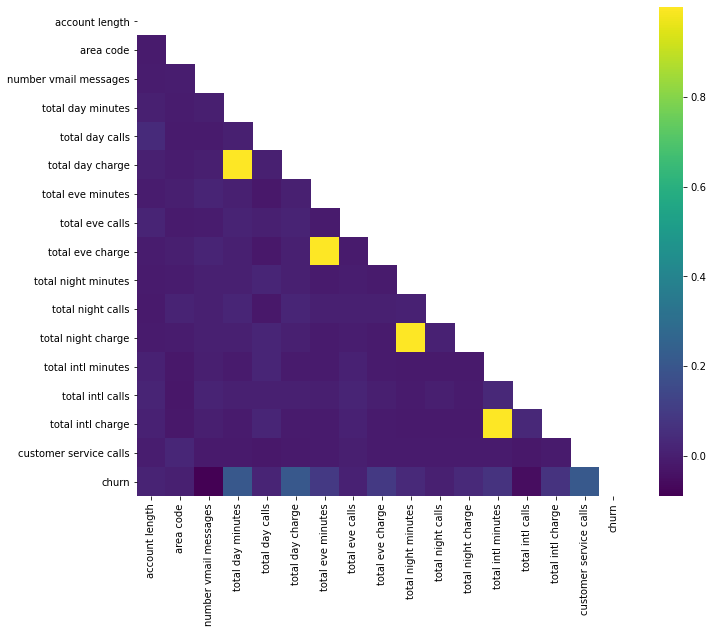

In [9]:
# using heat map to show the correlation between columns and churn
corr = df.corr()
# The mask is not necessary, but corr() has duplicate values on either side of the diagonal
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

Didn't find clear picture of correlation. It will be nice to spot some trends with a pairplot.

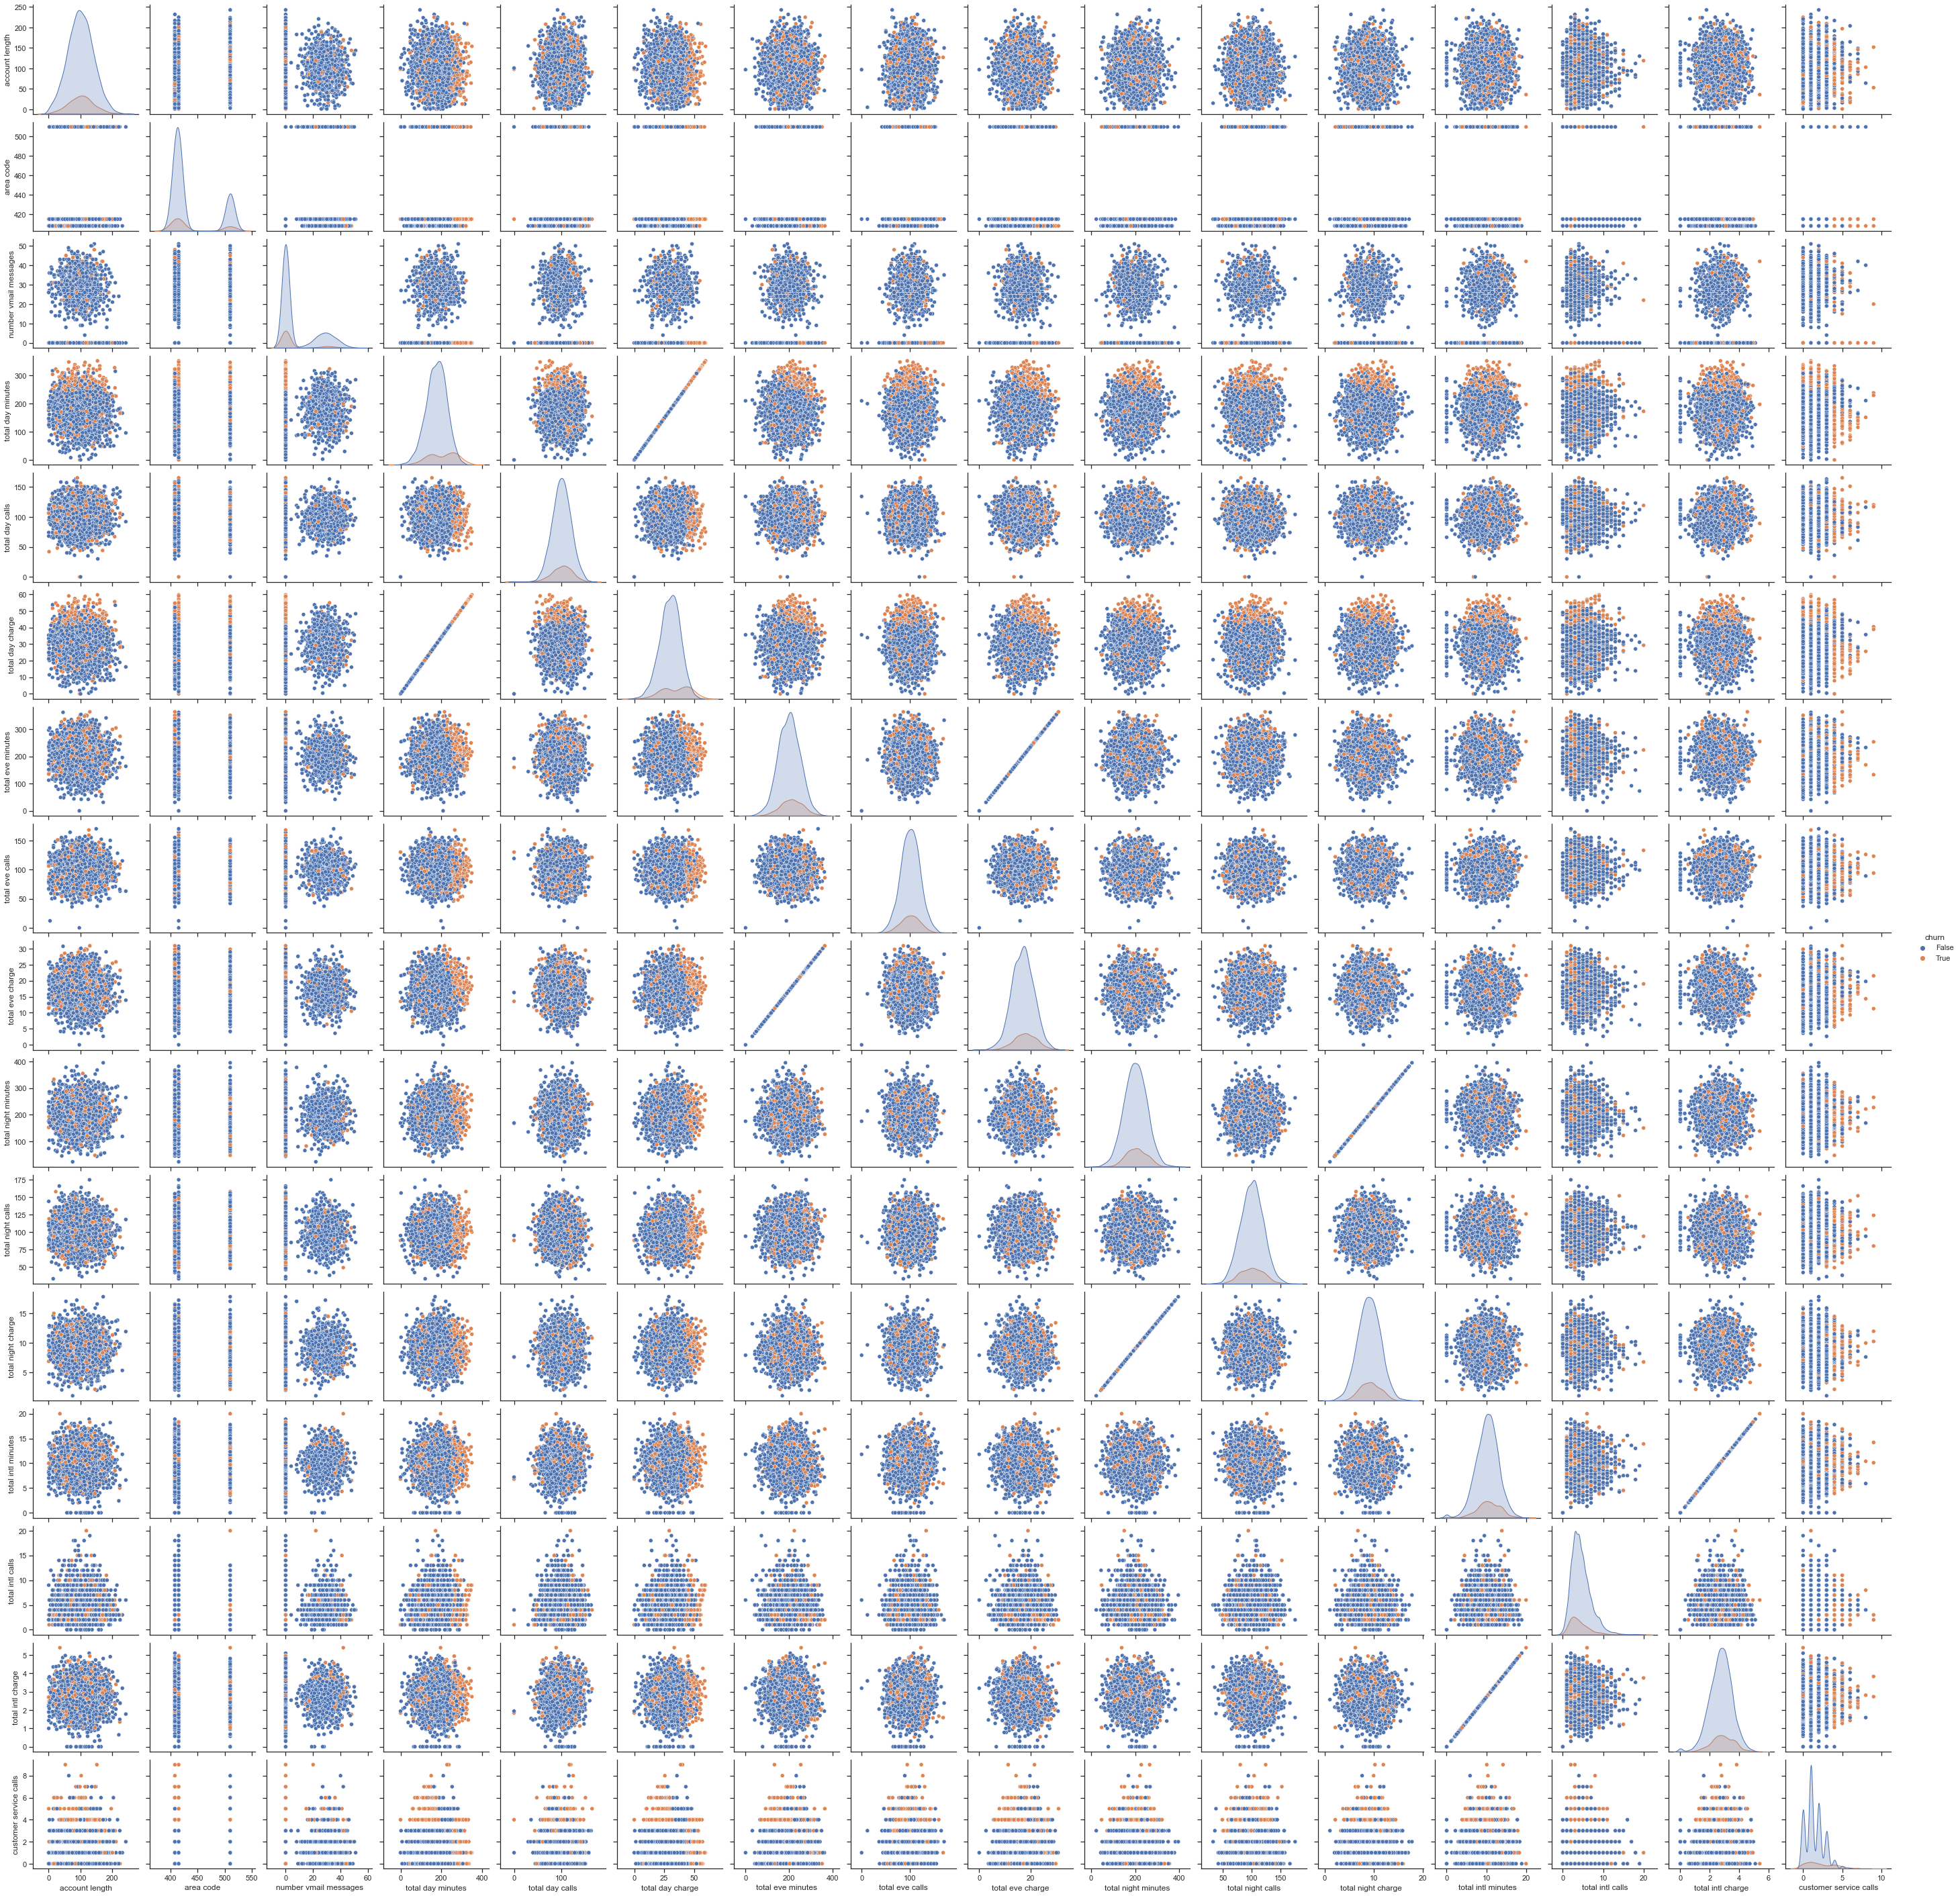

In [11]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df, hue='churn')

No surprise. Total Day Charge and Total Day Minutes are linearly correlated. So are Total International Minutes and Total International Minutes.

# Data Preparation

The data preparation phase covers all activities to construct the final dataset from the initial raw data.

In [13]:
# Create indendent and dependet series. 
# 'churn' is target data and rest training data
X = df.drop('churn', axis=1)
y = df['churn']

from sklearn.model_selection import train_test_split

# Let us do a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Data Preprocessing

In [14]:
df.drop(['phone number'], inplace=True, axis=1)

# Descriptive Analysis

What are the top 20 state where subscribers have high level of churn?

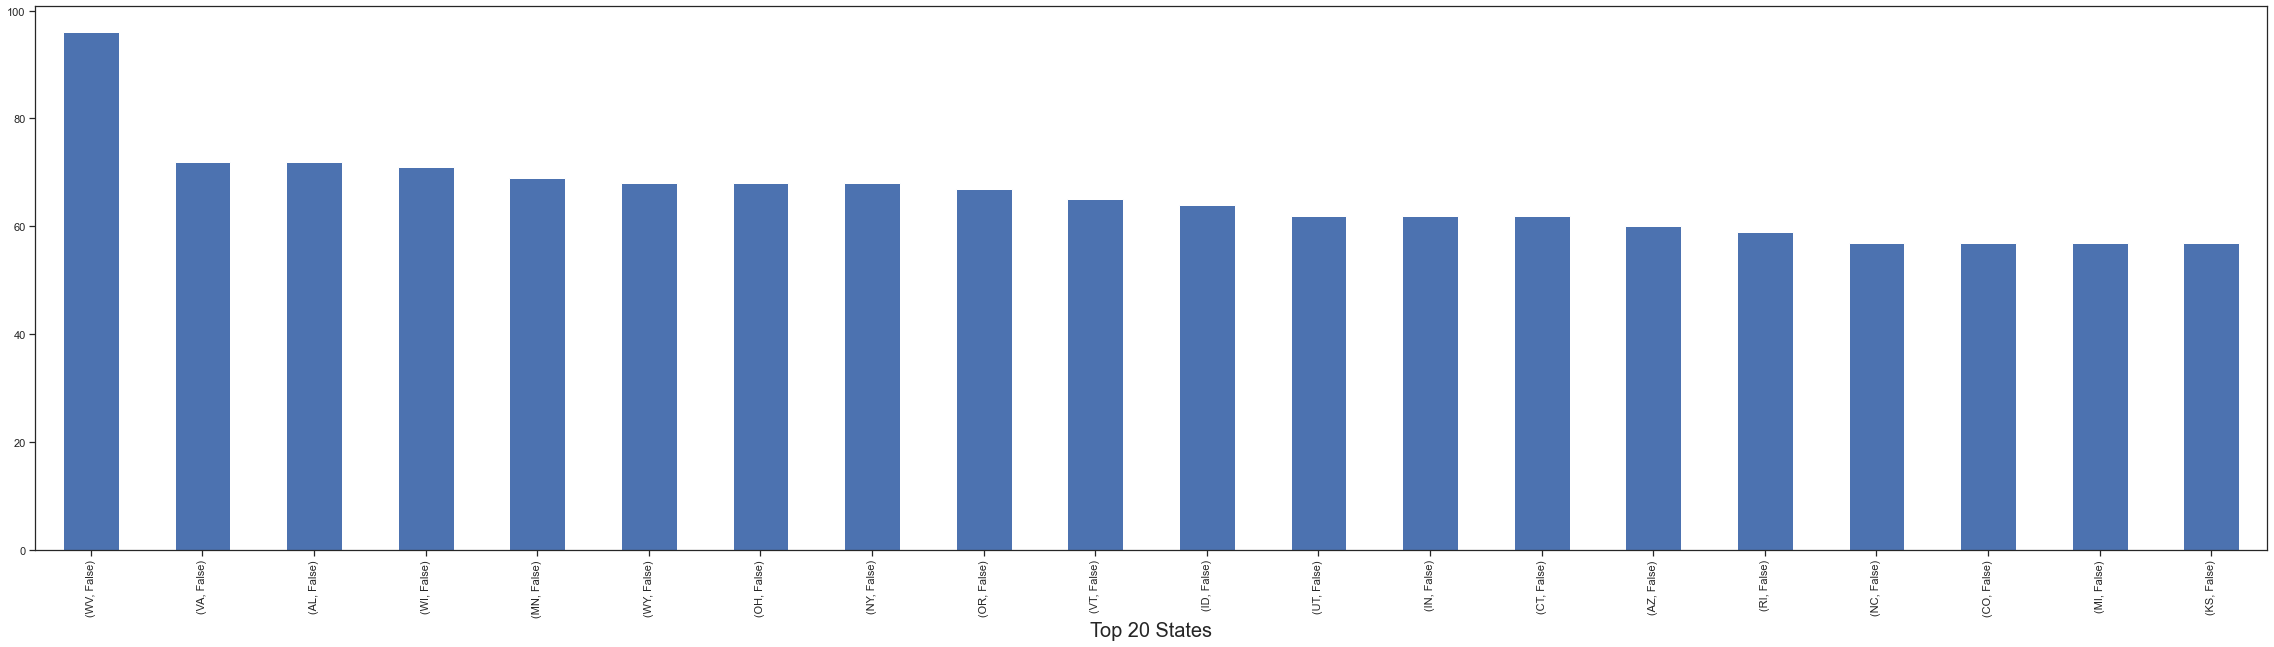

In [16]:
# Churn by State

plt.rcParams['font.size'] = '16'
df.groupby(["state", "churn"]).size().sort_values(ascending=False ).head(20).plot(kind='bar', stacked=False, figsize=(40, 10))
plt.xlabel('Top 20 States', fontsize=20)
plt.show()

# Handle categorical features

In [17]:
# Encode categorical features state, 'international plan', and 'voicemail plan'
label_encoder = preprocessing.LabelEncoder()

df['state'] = label_encoder.fit_transform(df['state'])
df['international plan'] = label_encoder.fit_transform(df['international plan'])
df['voice mail plan'] = label_encoder.fit_transform(df['voice mail plan'])

# drop column 'churn'
df.drop(['churn'], inplace=True, axis=1)

In [18]:
# Let us standardize all independent features
X = df.to_numpy().astype(np.float)

scaler = preprocessing.StandardScaler()

X = scaler.fit_transform(X)

<ipython-input-18-11e62f933d84>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = df.to_numpy().astype(np.float)


In [19]:
'''
    stratified_cv is a helper function to do StratifiedKfolot training and test data, fit the model, and predict with test data

'''
from sklearn.model_selection import cross_validate, StratifiedKFold

def stratified_cv(X, y, clf_class, shuffle=True, n_folds = 10, **kwargs):

    # copy labels to predict
    y_pred = y.copy()

    for train_index, test_index in StratifiedKFold(n_folds).split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        
        y_train, y_test = y[train_index], y[test_index]
        
        clf = clf_class(**kwargs)
        
        clf.fit(X_train , y_train)
        
        y_pred[test_index] = clf.predict(X_test)
        
    return y_pred

Looking at the scatterplot and the patterns of the target variable, I think the Logistic Regressing would perform the lowest.

In [20]:
#logistic Regression
logistic_regression = stratified_cv(X, y, linear_model.LogisticRegression)

#SVM
support_vector_machine = stratified_cv(X, y, svm.SVC)

# Gradient Boosting Classifier
gradient_boosting_classifier = stratified_cv(X, y, ensemble.GradientBoostingClassifier)

#Random Forest Classifier
random_forest_classifier = stratified_cv(X, y, ensemble.RandomForestClassifier)

#k_nearest_neighbor_classifier
k_nearest_neighbor_classifier = stratified_cv(X, y, neighbors.KNeighborsClassifier)

# Score the models

In [21]:
print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(y, gradient_boosting_classifier)))
print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(y, support_vector_machine)))
print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y, random_forest_classifier)))
print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y, k_nearest_neighbor_classifier)))
print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, logistic_regression)))

Gradient Boosting Classifier:  0.95
Support vector machine(SVM):   0.92
Random Forest Classifier:      0.95
K Nearest Neighbor Classifier: 0.89
Logistic Regression:           0.86


# Print Confustion Matrix

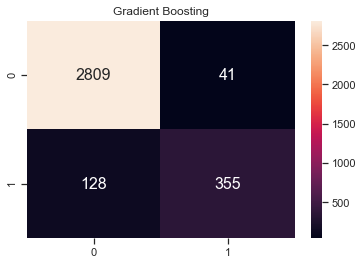

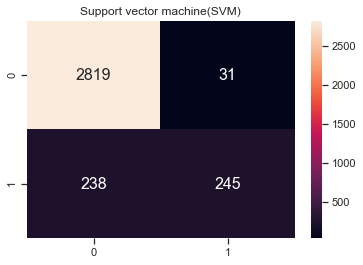

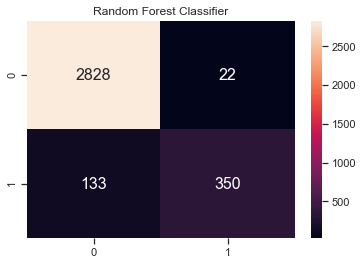

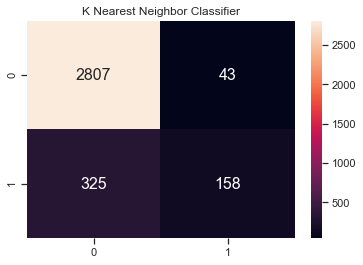

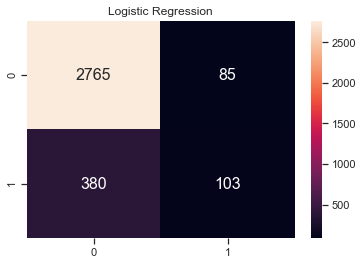

In [22]:
gcm = metrics.confusion_matrix(y, gradient_boosting_classifier)

sns.heatmap(gcm, annot=True, fmt='')
title='Gradient Boosting'
plt.title(title)
plt.show()


svm_cm = metrics.confusion_matrix(y, support_vector_machine)

sns.heatmap(svm_cm, annot=True, fmt='')
title='Support vector machine(SVM)'
plt.title(title)
plt.show()


rfc_cm = metrics.confusion_matrix(y, random_forest_classifier)

sns.heatmap(rfc_cm, annot=True, fmt='')
title='Random Forest Classifier'
plt.title(title)
plt.show()


knc_cm = metrics.confusion_matrix(y, k_nearest_neighbor_classifier)

sns.heatmap(knc_cm, annot=True, fmt='')
title='K Nearest Neighbor Classifier'
plt.title(title)
plt.show()


lr_cm = metrics.confusion_matrix(y, logistic_regression)

sns.heatmap(lr_cm, annot=True, fmt='')
title='Logistic Regression'
plt.title(title)
plt.show()

# Final Model Selection

In [23]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X, y)

GradientBoostingClassifier()

[0.00279408 0.00310345 0.00047565 0.09486837 0.02079516 0.06346991
 0.17416012 0.00385574 0.11644482 0.08638858 0.00135484 0.05596319
 0.00911149 0.00108371 0.00894319 0.03463229 0.11083774 0.04881774
 0.16289992]


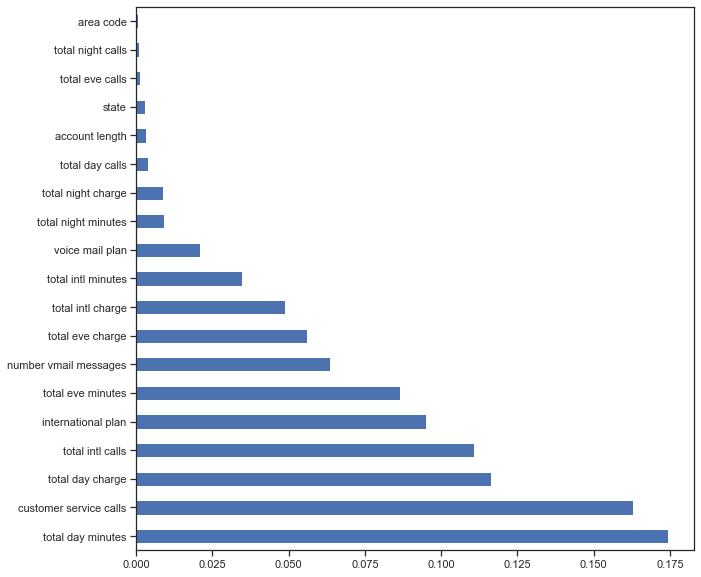

In [24]:
# find feature importance
feature_importance = gbc.feature_importances_

print (gbc.feature_importances_)

feat_importances = pd.Series(gbc.feature_importances_, index=df.columns)
feat_importances = feat_importances.nlargest(19)

feat_importances.plot(kind='barh' , figsize=(10,10)) 
plt.show();